## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [3]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sat Mar 30 23:46:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    N/A /  N/A |    720MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

cuda.select_device(0)
cuda.close()
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [5]:
train, test = keras.datasets.cifar10.load_data()

In [6]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
EPOCHS = 50
BATCH_SIZE = [32, 128, 256]

In [10]:
def model_fitting(learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        verbose=1)
    
    sess.close()

    return history

In [14]:
results = {}

for batch_size in BATCH_SIZE:
    
    history = model_fitting(batch_size=batch_size)
    
    name_tag = f'batch_size={batch_size}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

50000/50000 [==============================] - 19s 388us/step - loss: 0.0510 - acc: 0.9827 - val_loss: 3.8264 - val_acc: 0.5243
Epoch 48/50
50000/50000 [==============================] - 19s 382us/step - loss: 0.0454 - acc: 0.9850 - val_loss: 3.8296 - val_acc: 0.5211
Epoch 49/50
50000/50000 [==============================] - 20s 394us/step - loss: 0.0450 - acc: 0.9845 - val_loss: 3.9076 - val_acc: 0.5216
Epoch 50/50
50000/50000 [==============================] - 21s 425us/step - loss: 0.0487 - acc: 0.9835 - val_loss: 3.8836 - val_acc: 0.5205
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1

50000/50000 [==============================] - 8s 159us/step - loss: 0.0411 - acc: 0.9862 - val_loss: 3.6090 - val_acc: 0.5308
Epoch 44/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.0358 - acc: 0.9882 - val_loss: 3.6769 - val_acc: 0.5285
Epoch 45/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.0347 - acc: 0.9886 - val_loss: 3.7409 - val_acc: 0.5291
Epoch 46/50
50000/50000 [==============================] - 8s 160us/step - loss: 0.0315 - acc: 0.9898 - val_loss: 3.6766 - val_acc: 0.5319
Epoch 47/50
50000/50000 [==============================] - 8s 159us/step - loss: 0.0284 - acc: 0.9901 - val_loss: 3.7482 - val_acc: 0.5315
Epoch 48/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.0299 - acc: 0.9905 - val_loss: 3.7589 - val_acc: 0.5358
Epoch 49/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.0275 - acc: 0.9907 - val_loss: 3.7346 - val_acc: 0.5330
Epoch 50/50
50000/50000 [==============

50000/50000 [==============================] - 6s 113us/step - loss: 0.0554 - acc: 0.9813 - val_loss: 3.5603 - val_acc: 0.5188
Epoch 40/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.0495 - acc: 0.9830 - val_loss: 3.5443 - val_acc: 0.5221
Epoch 41/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.0457 - acc: 0.9851 - val_loss: 3.5967 - val_acc: 0.5213
Epoch 42/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.0438 - acc: 0.9858 - val_loss: 3.6019 - val_acc: 0.5254
Epoch 43/50
50000/50000 [==============================] - 5s 110us/step - loss: 0.0377 - acc: 0.9880 - val_loss: 3.5826 - val_acc: 0.5228
Epoch 44/50
50000/50000 [==============================] - 5s 109us/step - loss: 0.0324 - acc: 0.9901 - val_loss: 3.6453 - val_acc: 0.5280
Epoch 45/50
50000/50000 [==============================] - 6s 110us/step - loss: 0.0373 - acc: 0.9879 - val_loss: 3.7030 - val_acc: 0.5227
Epoch 46/50
50000/50000 [==============

In [15]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181', '#ffb07c']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

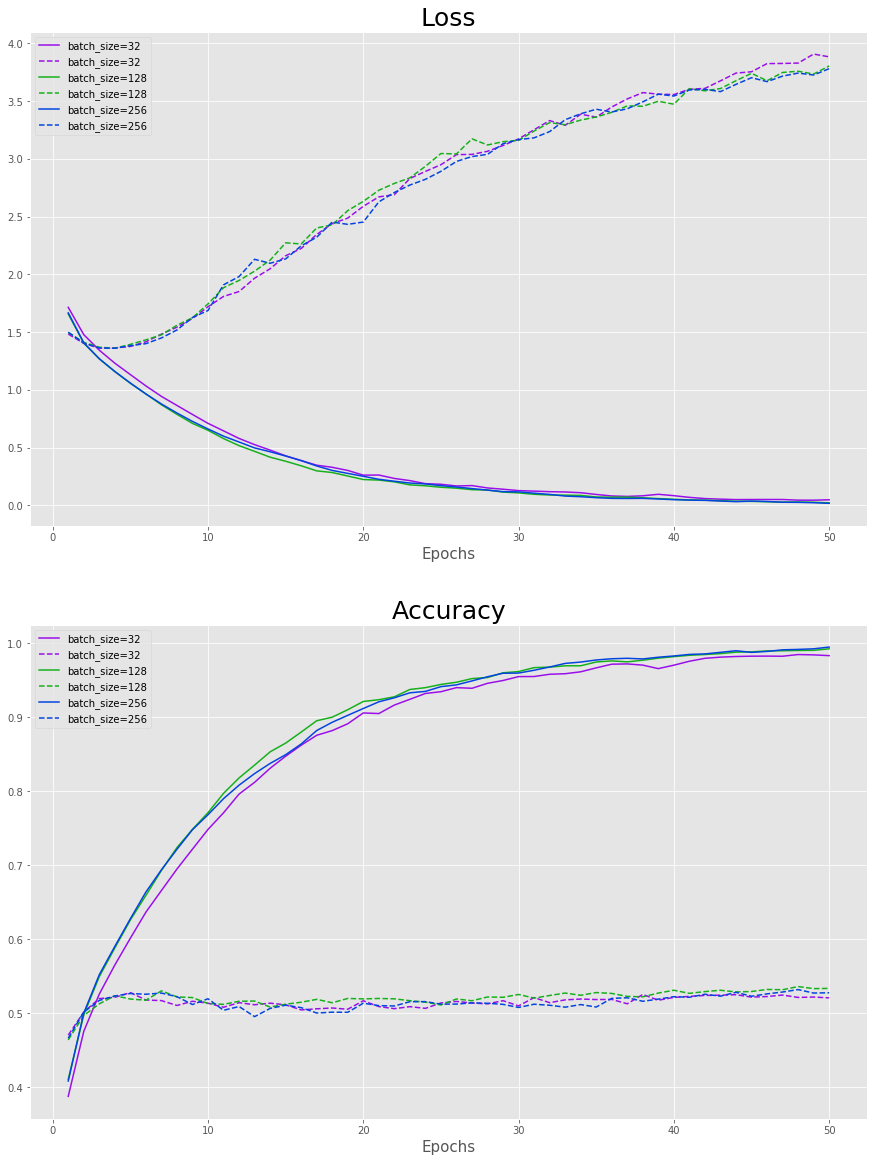

In [16]:
plotting(results)

In [ ]:
cuda.select_device(0)
cuda.close()